# Distilbert-base-cased without cleaning/preprocessing
(baseline)
Note that not all the cells in this notebook has outputs shown, because it is converted to an `.py` file and run in the SoC slurm clusters, then the model and results are copied back. But the notebook can be run here.

In [1]:
import torch

torch.cuda.empty_cache()

import gc

gc.collect()

0

In [2]:
SAVE_LOCATION = "results_distilbert-base-cased"

In [3]:
import pandas as pd
from io import StringIO

with open("raw_data/xtrain.txt", "r") as file:
    data = file.read()

text_stream = StringIO(data)

df = pd.read_csv(text_stream, sep='\t', header=None, names=['labels', 'text'])

In [ ]:
balanced_test = pd.read_csv("raw_data/balancedtest.csv", names=['labels', 'text'])

In [ ]:
balanced_test["labels"] -= 1
df["labels"] -= 1

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-cased")

In [ ]:
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        padding="max_length",
        return_tensors="pt"
    )

In [ ]:
from datasets import Dataset

df_dataset = Dataset.from_pandas(df)

In [ ]:
tokenized_df = df_dataset.map(preprocess_function, batched=True)

In [ ]:
from transformers import DataCollatorWithPadding, DataCollator

data_collator = DataCollatorWithPadding(tokenizer)

In [ ]:
import numpy as np
from transformers import EvalPrediction
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(p: EvalPrediction):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")
    accuracy = accuracy_score(labels, predictions)
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [ ]:
id2label = {0: "0", 1: "1", 2: "2", 3: "3"}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-cased", num_labels=4, id2label=id2label, label2id=label2id
)

In [ ]:
test_df = Dataset.from_pandas(balanced_test)
tokenized_test_df = test_df.map(preprocess_function, batched=True)


In [ ]:
training_args = TrainingArguments(
    output_dir="results",
    # learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    evaluation_strategy="epoch",
    save_strategy="epoch",

    logging_dir="logs",
    logging_steps=100,

    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_df,
    eval_dataset=tokenized_test_df,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [29]:
trainer.save_model(SAVE_LOCATION)
tokenizer.save_pretrained(SAVE_LOCATION)

Saving model checkpoint to results
Configuration saved in results\config.json
Model weights saved in results\pytorch_model.bin
tokenizer config file saved in results\tokenizer_config.json
Special tokens file saved in results\special_tokens_map.json
tokenizer config file saved in results\tokenizer_config.json
Special tokens file saved in results\special_tokens_map.json


('results\\tokenizer_config.json',
 'results\\special_tokens_map.json',
 'results\\vocab.txt',
 'results\\added_tokens.json',
 'results\\tokenizer.json')

In [30]:
# trainer.push_to_hub()

In [40]:
loaded_model = AutoModelForSequenceClassification.from_pretrained(f"{SAVE_LOCATION}/")
loaded_tokenizer = AutoTokenizer.from_pretrained(f"{SAVE_LOCATION}/")

loading configuration file results/config.json
Model config DistilBertConfig {
  "_name_or_path": "results/",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "0",
    "1": "1",
    "2": "2",
    "3": "3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "vocab_size": 28996
}

loading weights file results/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weigh

In [41]:
from transformers import pipeline

classifier = pipeline("text-classification",
                      model=loaded_model,
                      tokenizer=loaded_tokenizer, max_length=512,
                      truncation=True,
                      device_map="auto",
                      )

In [42]:
test_df

Dataset({
    features: ['labels', 'text'],
    num_rows: 3000
})

In [43]:
from tqdm import tqdm
from transformers.pipelines.base import KeyDataset

results = []
short_df = test_df  # .select(range(10))
for out in tqdm(classifier(KeyDataset(short_df, "text"))):
    extracted_label = out["label"][-1]
    results.append(extracted_label)

100%|██████████| 3000/3000 [24:24<00:00,  2.05it/s]


In [47]:
predicted_results_df = pd.DataFrame(results)
predicted_results_df.to_csv(f"{SAVE_LOCATION}/predicted_results.csv", index=False)
print(predicted_results_df)

      0
0     0
1     0
2     0
3     3
4     0
...  ..
2995  3
2996  3
2997  3
2998  3
2999  3

[3000 rows x 1 columns]


In [48]:
from sklearn.metrics import classification_report

label_str = balanced_test["labels"].astype(str)
clf_report = classification_report(label_str, predicted_results_df)
print(clf_report)


              precision    recall  f1-score   support

           0       0.91      0.86      0.88       750
           1       0.93      0.65      0.76       750
           2       0.07      0.03      0.04       750
           3       0.49      0.98      0.66       750

    accuracy                           0.63      3000
   macro avg       0.60      0.63      0.58      3000
weighted avg       0.60      0.63      0.58      3000


In [ ]:
"""
Output:

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       750
           1       0.93      0.65      0.76       750
           2       0.07      0.03      0.04       750
           3       0.49      0.98      0.66       750

    accuracy                           0.63      3000
   macro avg       0.60      0.63      0.58      3000
weighted avg       0.60      0.63      0.58      3000

"""

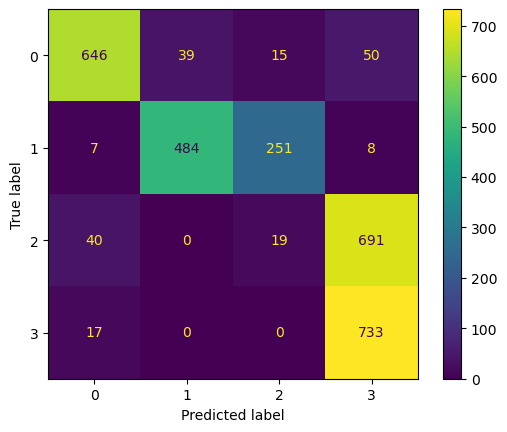

In [3]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

balanced_test = pd.read_csv("raw_data/balancedtest.csv", names=['labels', 'text'])
pred_results = pd.read_csv("results_distilbert-base-cased/predicted_results.csv")

balanced_test.labels -= 1

cm = confusion_matrix(balanced_test["labels"].astype(int), pred_results.astype(int))
ConfusionMatrixDisplay(cm).plot()
